<a href="https://colab.research.google.com/github/HenrySomeCode/Text-Classifiation-using-Bidirectional-LSTM/blob/main/Text_Classifiation_using_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref:

* https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
# load data
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# split data into train, test
train_dataset, test_dataset = dataset['train'],dataset['test']

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# review a sample from the train_dataset. A sample includes an example, mean a review
# and a label which either be 0 - negative or 1 - positive
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Configure the dataset for performance**

There are two methods that can be used when loading data to make sure I/O (reading/writing from/to disk) doesn't slow down the training process:

* .cache() keeps data in memory (RAM) instead of only on disk by loading data from disk. This makes access to data faster since we don't need to read data from disk again.

* .prefetch() is used to overlap the data preprocessing and model execution. This means that while the model is training on a batch of data, the next batch is being preprocessed in the background. By overlapping these two steps, the overall training process becomes more efficient, as the model doesn't have to wait for the data preprocessing to finish before it can start training on the next batch. This can significantly improve the training speed, especially when the data preprocessing is computationally intensive.

In [5]:
# shuffle the data for training and create batches that each bach contains (text, label)

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
# review a batch of samples from the train_dataset. A batch of samples includes 64 samples.
# A sample includes an example, mean a review and a label which either be 0 - negative
# or 1 - positive.
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  [b'One of the most appealing elements of a Gilliam film is that the well-concocted visuals, the unsettling backdrops, and the manically frustrated characters are evidence of the creator\'s involvement. Instead of most movies (where the filmmaker is some director-for-hire that is paid to feature a star or two), you can feel Terry Gilliam\'s presence through the experience. "12 Monkeys" is evidence of Gilliam\'s own vision and style, as opposed to making offbeat movies for their own sake. "12 Monkeys" is a variation on similar themes of Gilliam\'s repertoire:oppressive/recessive societies, the solitude of the protagonist, the frustration associated with disbelief, and parallel realms. In this film Gilliam does a fine job of blurring lines between the two realms, using ambiguities to force the audience to believe rather than know. This tendency for Gilliam to neglect to fill in certain gaps leads to criticisms of art-house pretentiousness. The difference between Gilliam and artsy p

Text Preprocessing Layer (Encoder Layer)

Why is vocab_size equal to 1000? Why not the whole words in the training dataset?

Here are a few reasons why a limited vocabulary size might be used:

* Efficiency: Limiting the vocabulary size helps manage the computational complexity and memory requirements of the model

* Generalization: a large vocabulary may include rare or infrequent words that do not provide much information for the model. By focusing on the most frequent words, the model can generalize better for not only seen but unseen data.


In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to have the same size as the tensor of indices of the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 29,   5,   2, ...,   0,   0,   0],
       [168, 715,  60, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0]])

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

# UNK - UNKOWN WORD

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In my opinion, with the default settings of TextVectorization, the process of converting from words to numbers, or from sequences to tensors of numbers is not completely perfect. These are reasons:

* The default value for TextVectorization's standardize argument is "lower_and_strip_punctuation" which means the model will not perform well when it comes to things related to lowercase or uppercase, or punctuation. We can see this via the below code.

* The limited vocabulary size and lack of character-based fall back reults in some unknown tokens

*Note: as far as I know, "Character-based fallback" refers to a strategy used when dealing with unknown or out-of-vocabulary (OOV) words during text processing or tokenization.*

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'One of the most appealing elements of a Gilliam film is that the well-concocted visuals, the unsettling backdrops, and the manically frustrated characters are evidence of the creator\'s involvement. Instead of most movies (where the filmmaker is some director-for-hire that is paid to feature a star or two), you can feel Terry Gilliam\'s presence through the experience. "12 Monkeys" is evidence of Gilliam\'s own vision and style, as opposed to making offbeat movies for their own sake. "12 Monkeys" is a variation on similar themes of Gilliam\'s repertoire:oppressive/recessive societies, the solitude of the protagonist, the frustration associated with disbelief, and parallel realms. In this film Gilliam does a fine job of blurring lines between the two realms, using ambiguities to force the audience to believe rather than know. This tendency for Gilliam to neglect to fill in certain gaps leads to criticisms of art-house pretentiousness. The difference between Gilliam and arts

Create the model

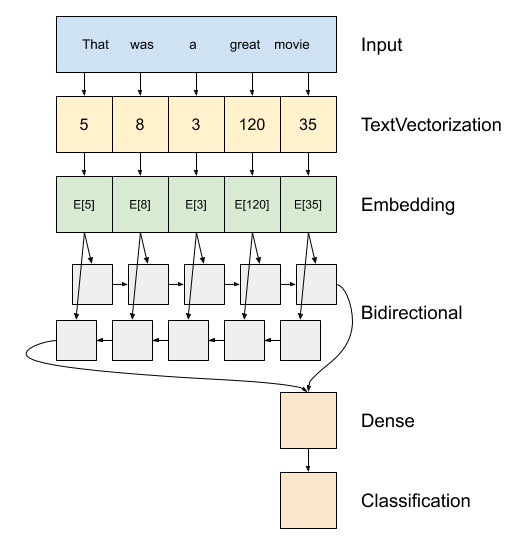

[Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn ]

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()), # 1000 : the lookup table's height
        output_dim = 64, # the lookup table's width
        # Use 'mask_zero=True' to handle the variable sequence lengths.
        # If mask_zero is set to True, then index 0 meaning ''
        # cannot be used in the vocabulary
        mask_zero=True
    ),
    # tf.keras.layers.Bidirectional(tf.keras.layers.RNN(64)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    # Total of batches of the validation set to draw a plot each epoch
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 109ms/step - loss: 0.6426 - accuracy: 0.5659 - val_loss: 0.5659 - val_accuracy: 0.7630
Epoch 2/10
391/391 [==============================] - 29s 72ms/step - loss: 0.4297 - accuracy: 0.8072 - val_loss: 0.3758 - val_accuracy: 0.8240
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3598 - accuracy: 0.8422 - val_loss: 0.3860 - val_accuracy: 0.8120
Epoch 4/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3309 - accuracy: 0.8574 - val_loss: 0.3353 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3195 - accuracy: 0.8648 - val_loss: 0.3252 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3129 - accuracy: 0.8673 - val_loss: 0.3273 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3109 - accuracy: 0.8683 - val_loss: 0.3310 - val_accuracy

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 32ms/step - loss: 0.3250 - accuracy: 0.8639
Test Loss: 0.325044721364975
Test Accuracy: 0.8639199733734131


(0.0, 0.6595896109938622)

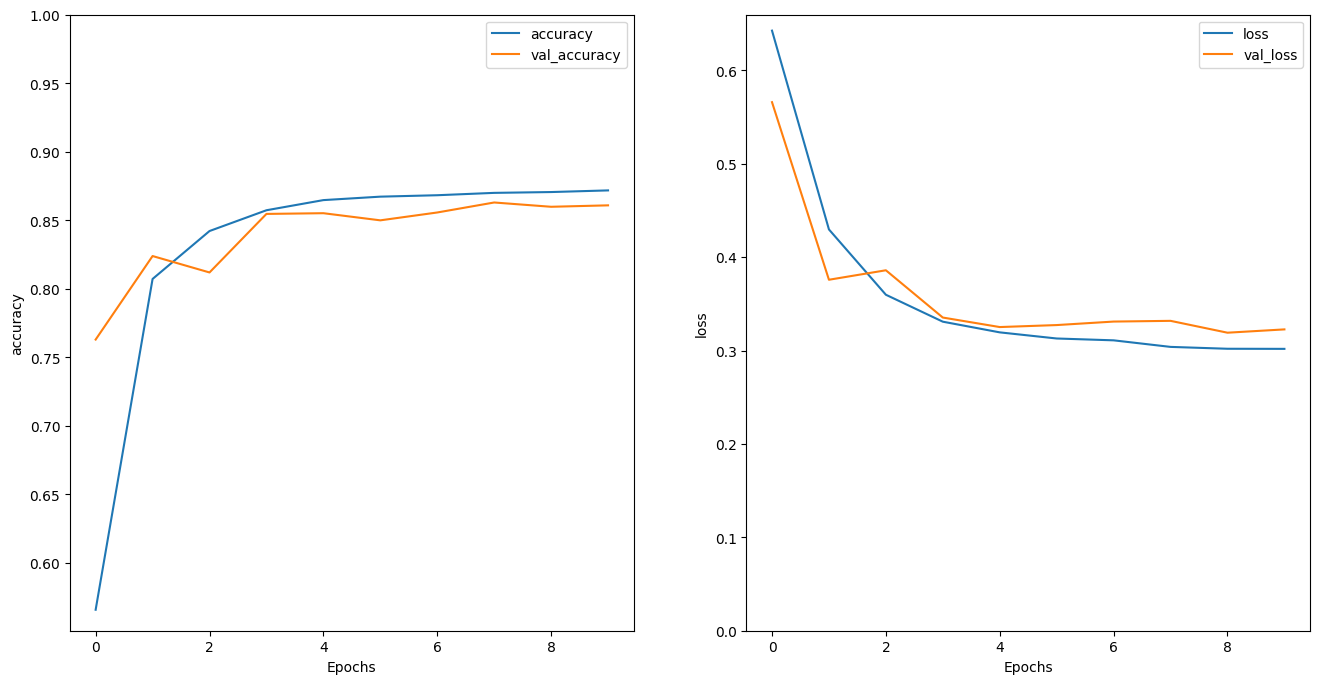

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.64157635]


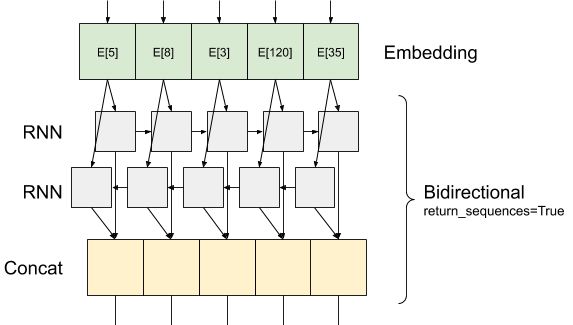

In [31]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
    # tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [33]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 161ms/step - loss: 0.6204 - accuracy: 0.5857 - val_loss: 0.4453 - val_accuracy: 0.7625
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3929 - accuracy: 0.8294 - val_loss: 0.3584 - val_accuracy: 0.8255
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3367 - accuracy: 0.8561 - val_loss: 0.3294 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3269 - accuracy: 0.8589 - val_loss: 0.3272 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3114 - accuracy: 0.8661 - val_loss: 0.3291 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3076 - accuracy: 0.8681 - val_loss: 0.3246 - val_accuracy: 0.8458
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3005 - accuracy: 0.8677 - val_loss: 0.3136 - val_ac

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3167 - accuracy: 0.8550
Test Loss: 0.31671372056007385
Test Accuracy: 0.854960024356842


In [36]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
# print(tf.math.sigmoid())

1/1 [==============================] - 0s 25ms/step
[-1.8538959]


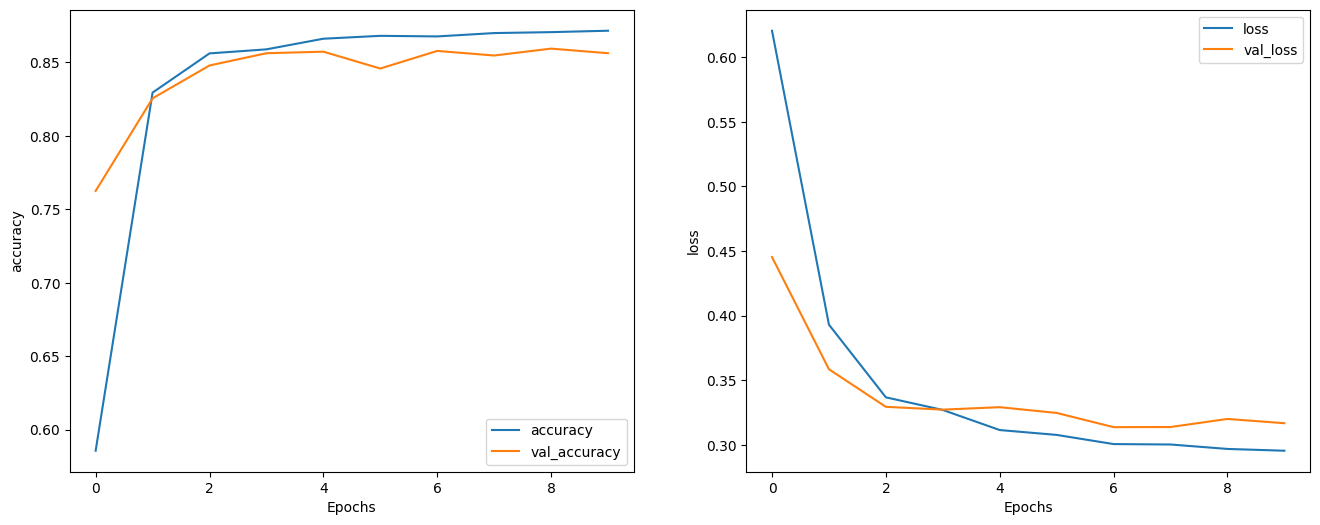

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')